# Data Analysis 

In this section, we conduct an analysis of the data required for our study and conclude by constructing the dataset that will be used in the following steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import random


In [2]:
df = pd.read_parquet('ourdata/static_dataset_session_757216464.parquet')

The dataset we are working with includes the following elements:

- **'stimulus_presentation_id'**: The ID of the stimulus presentation.
- **'unit_id'**: The ID of the neuron.
- **'spatial_frequency'**: How much the stimulus is structured.
- **'orientation'**: The angle at which the stimulus is oriented.
- **'spikes_per_second'**: The number of spikes per second recorded from the neuron in response to the stimulus.
- **'area'**: The area of the brain where the neuron is located.

In [3]:
df

,stimulus_presentation_id,unit_id,stimulus_name,spatial_frequency,orientation,spikes_per_second,area
index,,,,,,,
0,49434,951797083,static_gratings,0.32,0.0,43.964810,MGm
1,49434,951797141,static_gratings,0.32,0.0,43.964810,MGm
2,49434,951797185,static_gratings,0.32,0.0,19.984004,MGm
3,49434,951797253,static_gratings,0.32,0.0,23.980805,MGm
4,49434,951797285,static_gratings,0.32,0.0,7.993602,MGm
...,...,...,...,...,...,...,...
3250866,70389,951820289,static_gratings,0.04,150.0,7.993529,CA1
3250867,70389,951820298,static_gratings,0.04,150.0,27.977350,CA1
3250868,70389,951820332,static_gratings,0.04,150.0,3.996764,VISal


We begin our analysis by checking for duplicates and NaN values, verifying that the data is of the correct type for our analysis (i.e., numerical values for all variables except 'stimulus_name' and 'area'), and reviewing general information about the distribution of the variables.

In [4]:
print(df.duplicated().sum())

0


We have no duplicates in our dataset.

In [5]:
print(df.isnull().sum())

stimulus_presentation_id    0
unit_id                     0
stimulus_name               0
spatial_frequency           0
orientation                 0
spikes_per_second           0
area                        0
dtype: int64


We have no Nan values in our dataset.

In [8]:
print(df.dtypes)

stimulus_presentation_id      int64
unit_id                       int64
stimulus_name                object
spatial_frequency           float64
orientation                 float64
spikes_per_second           float64
area                         object
dtype: object


All variables are of correct type.

In [9]:
print(df.describe())

       stimulus_presentation_id       unit_id  spatial_frequency  \
count              3.150075e+06  3.150075e+06       3.150075e+06   
mean               5.852932e+04  9.518093e+08       1.235491e-01   
std                8.148448e+03  7.655798e+03       1.089519e-01   
min                4.943400e+04  9.517971e+08       2.000000e-02   
25%                5.072900e+04  9.518016e+08       4.000000e-02   
50%                5.605700e+04  9.518105e+08       8.000000e-02   
75%                6.884800e+04  9.518168e+08       1.600000e-01   
max                7.038900e+04  9.518205e+08       3.200000e-01   

        orientation  spikes_per_second  
count  3.150075e+06       3.150075e+06  
mean   7.497039e+01       1.474008e+01  
std    5.127796e+01       1.332359e+01  
min    0.000000e+00       3.996402e+00  
25%    3.000000e+01       3.996764e+00  
50%    6.000000e+01       1.198968e+01  
75%    1.200000e+02       1.998301e+01  
max    1.500000e+02       3.237312e+02  


We are focusing on the static_gratings as stimuli. 
Each static_grating has two main characteristics which are orientation and spatial_frequency. 

Let's look at the possible values these features can take.

In [10]:
print("STATIC GRATINGS")
print('Possible values:')
print(' - Orientation: ', df['orientation'].unique())
print(' - Spatial_frequency: ', df['spatial_frequency'].unique())

STATIC GRATINGS
Possible values:
 - Orientation:  [  0.  90. 120.  60. 150.  30.]
 - Spatial_frequency:  [0.32 0.04 0.16 0.08 0.02]


Let's now see how many datapoints we have of each values of spatial frequency, orientation and area.

<Axes: xlabel='spatial_frequency', ylabel='count'>

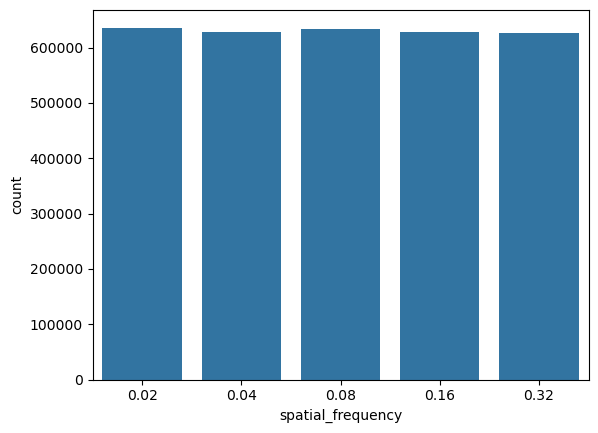

In [11]:
sns.countplot(x='spatial_frequency', data=df)

<Axes: xlabel='orientation', ylabel='count'>

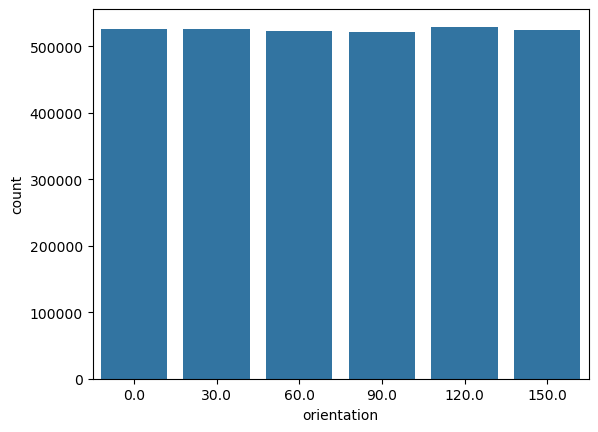

In [12]:
sns.countplot(x='orientation', data=df)

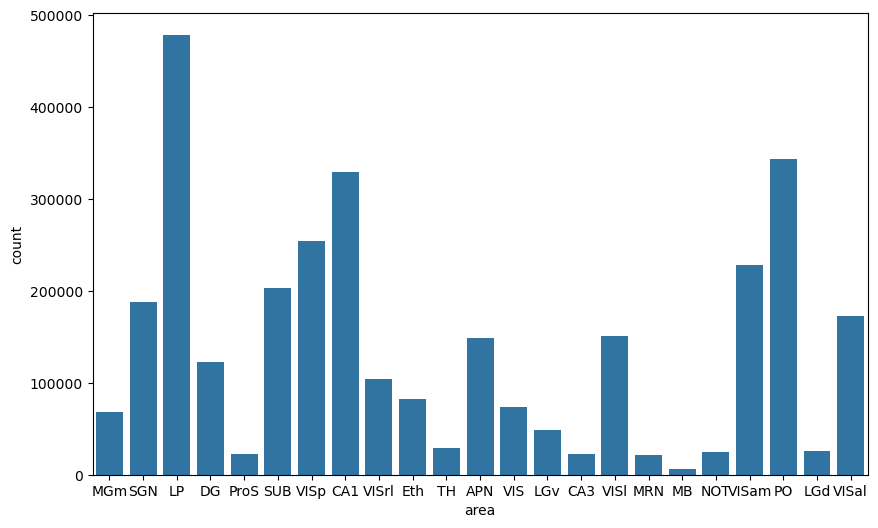

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='area', data=df)
plt.show()

As we can see, we have almost an equal number of counts for temporal frequency and orientation, while for the area, some values appear more frequently than others.

## Normalization

Let's now look at the distribution of the spikes per second.

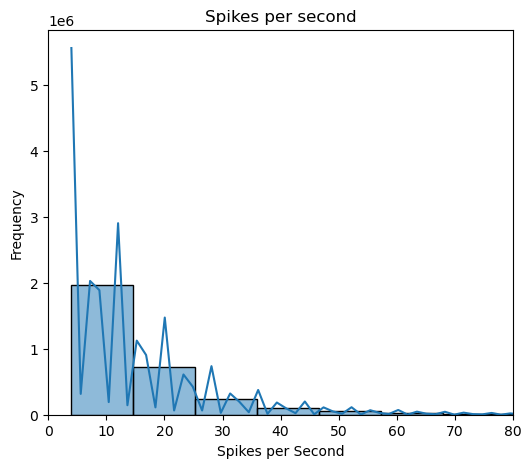

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(df['spikes_per_second'], kde=True, bins=30, ax=ax)

ax.set_title("Spikes per second")
ax.set_xlabel("Spikes per Second")
ax.set_ylabel("Frequency")
ax.set_xlim(left=0, right=80)  

plt.show()


We see that the distribution is highly skewed to the left. This means that we have lots of neurons which have a few number of spikes per second. 

In order to reduce this we try to apply log tranformation, square root transformation and box-cox transformation.

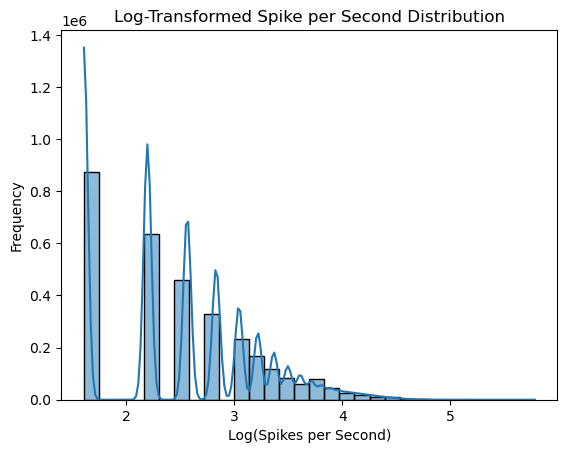

In [15]:
df["log_spikes"] = np.log1p(df["spikes_per_second"])  
sns.histplot(df["log_spikes"], kde=True, bins=30)
plt.title("Log-Transformed Spike per Second Distribution")
plt.xlabel("Log(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()


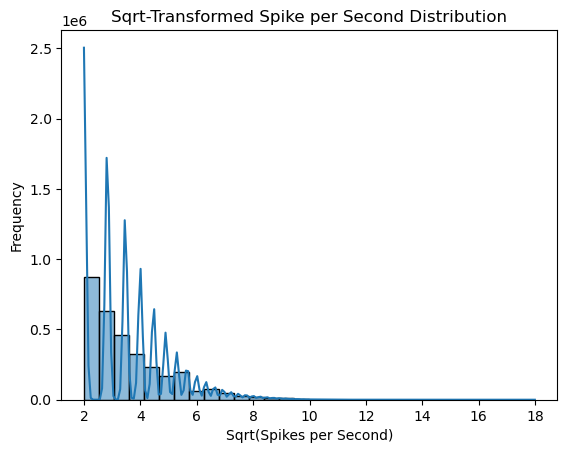

In [16]:
df["sqrt_spikes"] = np.sqrt(df["spikes_per_second"])
sns.histplot(df["sqrt_spikes"], kde=True, bins=30)
plt.title("Sqrt-Transformed Spike per Second Distribution")
plt.xlabel("Sqrt(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()

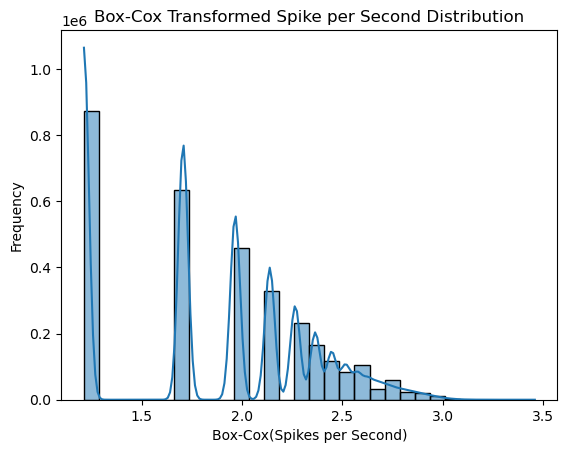

In [17]:
df["boxcox_spikes"], _ = stats.boxcox(df["spikes_per_second"])
sns.histplot(df["boxcox_spikes"], kde=True, bins=30)
plt.title("Box-Cox Transformed Spike per Second Distribution")
plt.xlabel("Box-Cox(Spikes per Second)")
plt.ylabel("Frequency")
plt.show()


No tranformation works correctly to make the data assume a normal distribution.

Let's now look better at the structure of the data using a boxplot.

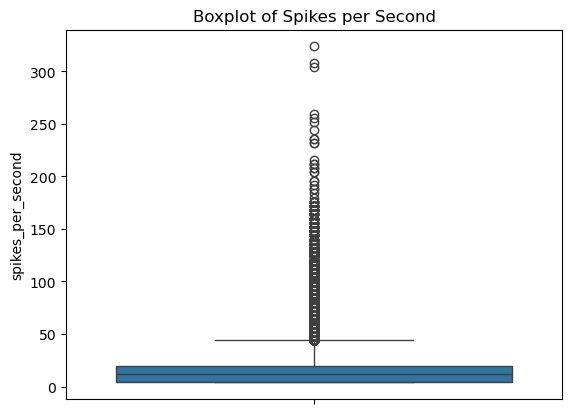

In [18]:
sns.boxplot(y=df["spikes_per_second"])
plt.title("Boxplot of Spikes per Second")
plt.show()


As we can see we have a big concentration of points in the range 0-20 and lots of outliers with larger values.

## Correlation

We now look at the correlation between spatial frequency and spikes per second and between orientation and spikes per second.

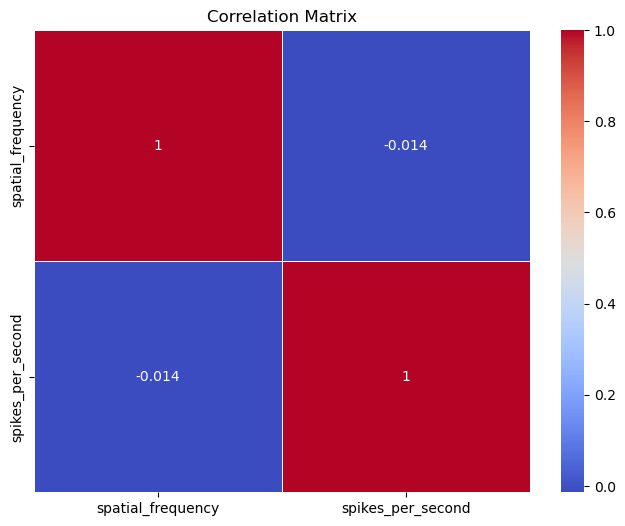

In [19]:
correlation_matrix = df[['spatial_frequency', 'spikes_per_second']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


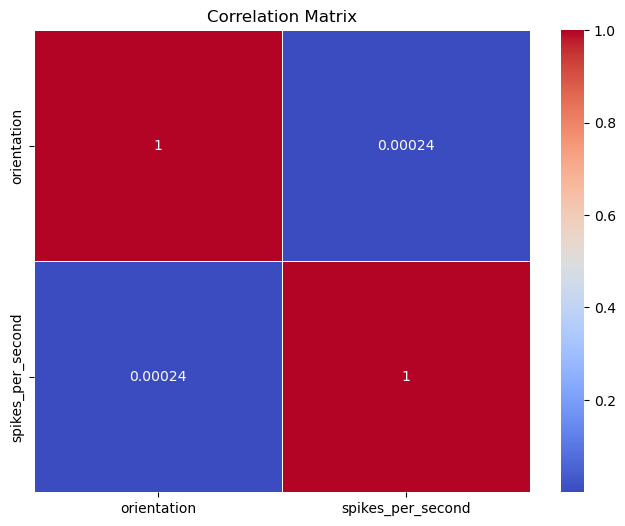

In [20]:
correlation_matrix = df[['orientation', 'spikes_per_second']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


As we can see we don't have direct linear relationship between the orientation and the spikes per second and between the spatial frequency and the spikes per second. This is consistent with our hypothesis, which is that a certain combination of orientation and spatial frequency causes different effects in each part of the brain.

## analysis of areas structure

We now focus on analysis the areas we will consider. What we want to see in particular is if each neuron of the area has similar reaction to a certain 
stimulus.

We do so by picking four areas and plot the values of spike per second for each neuron in the case of four different stimulus.

/var/folders/l5/l2yq9xlj55l1p5qsn5c6n5wh0000gn/T/ipykernel_73471/359427858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 4)


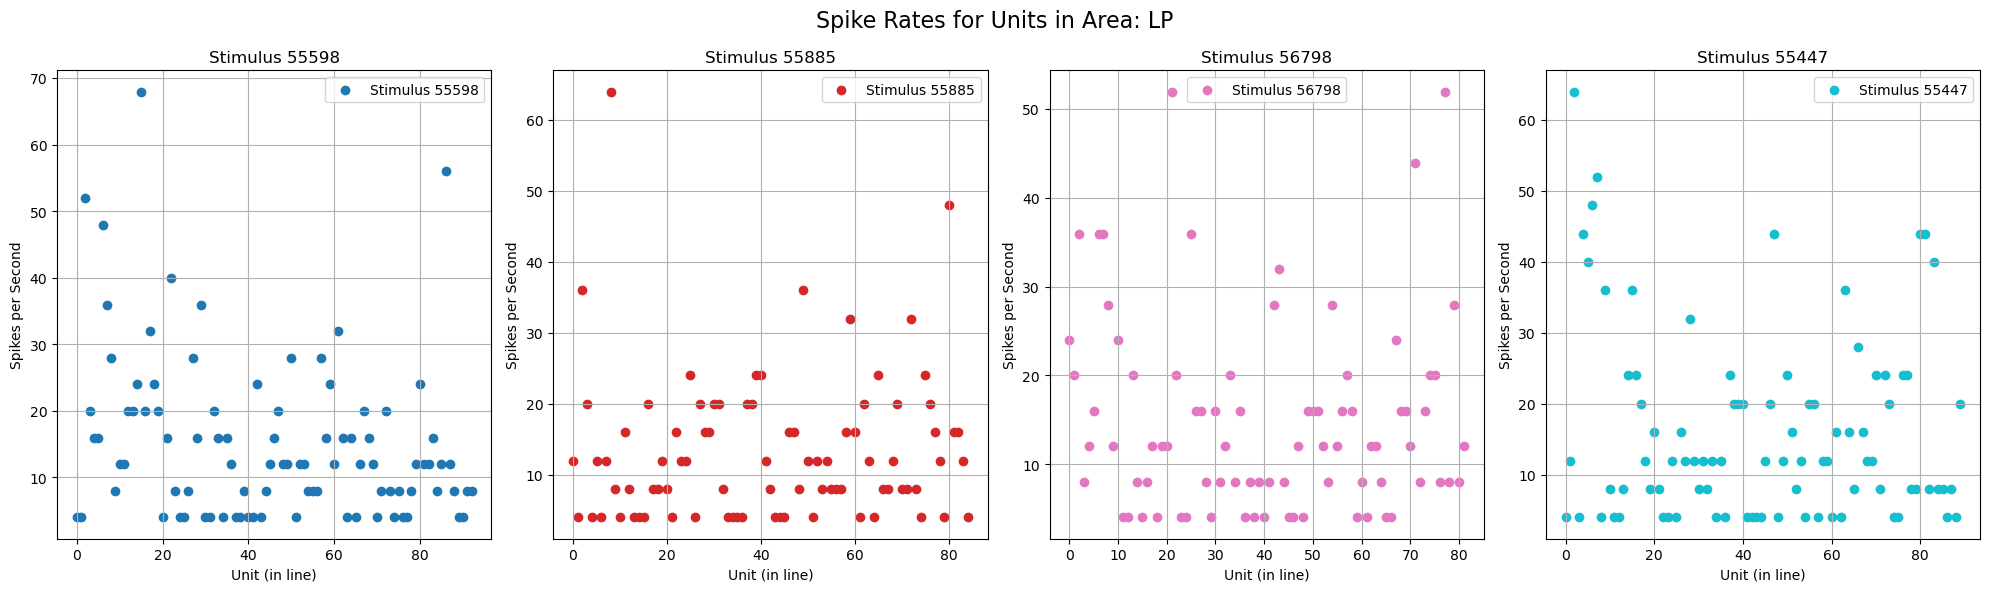

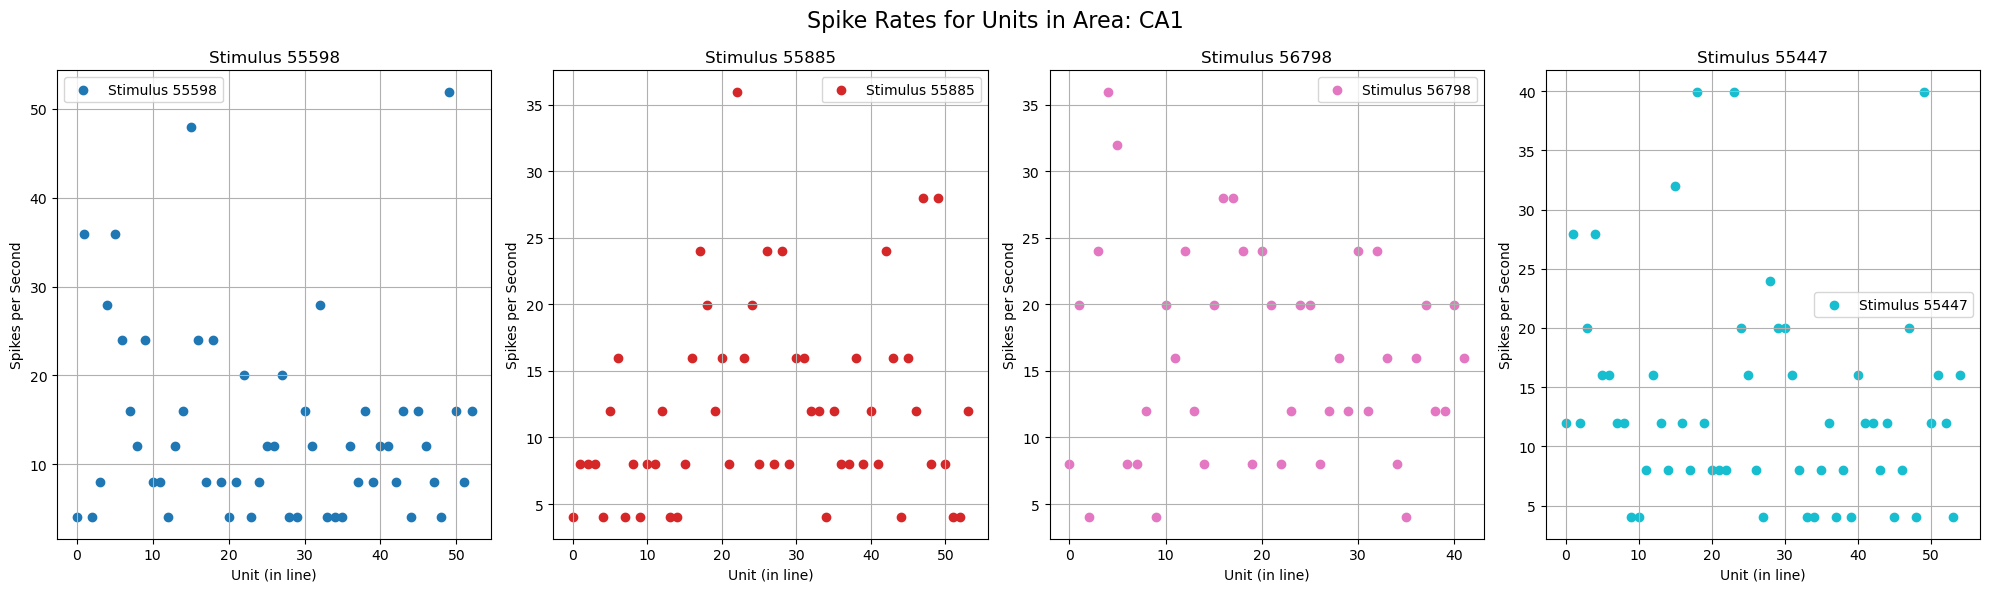

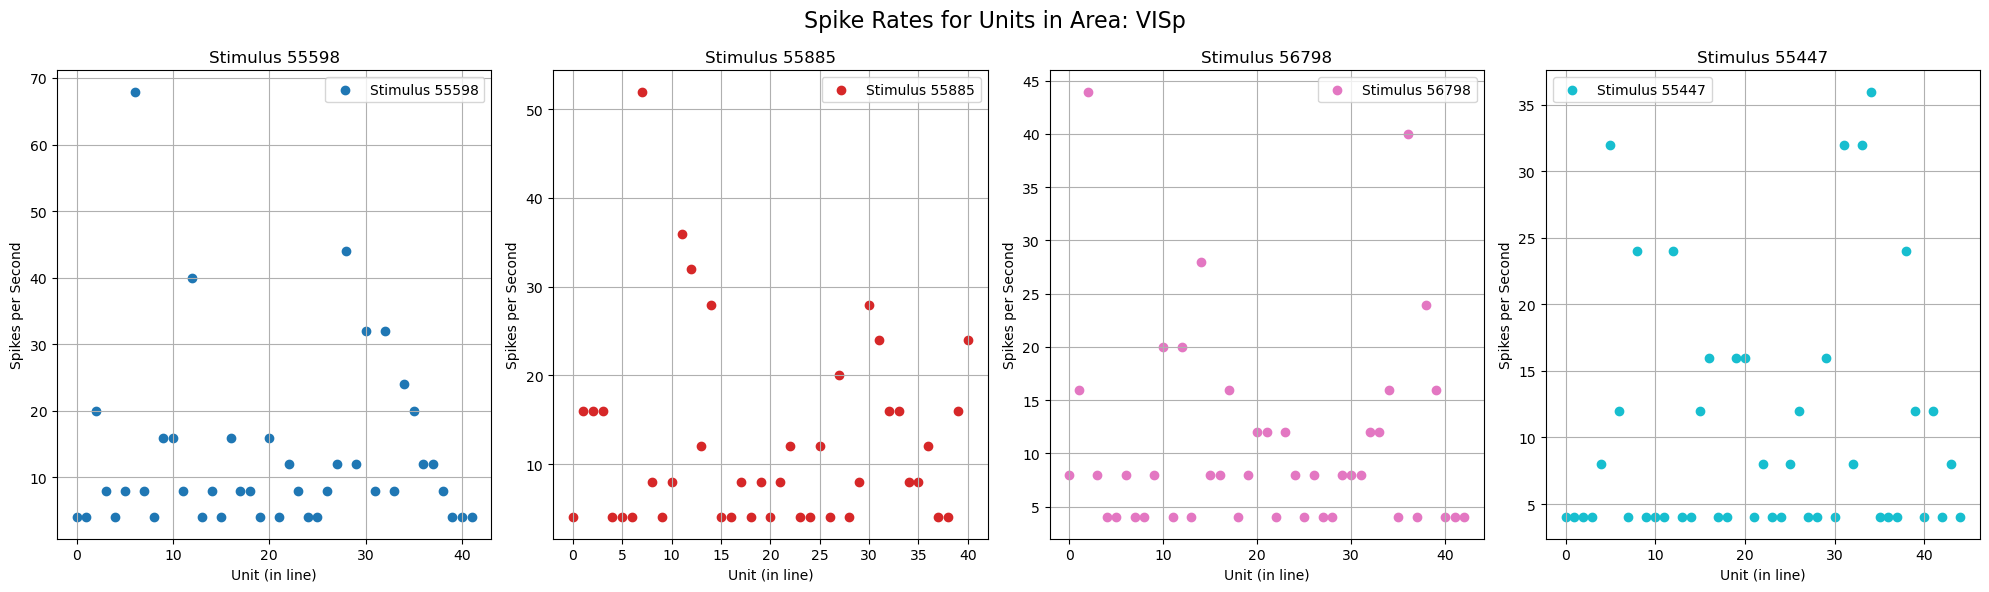

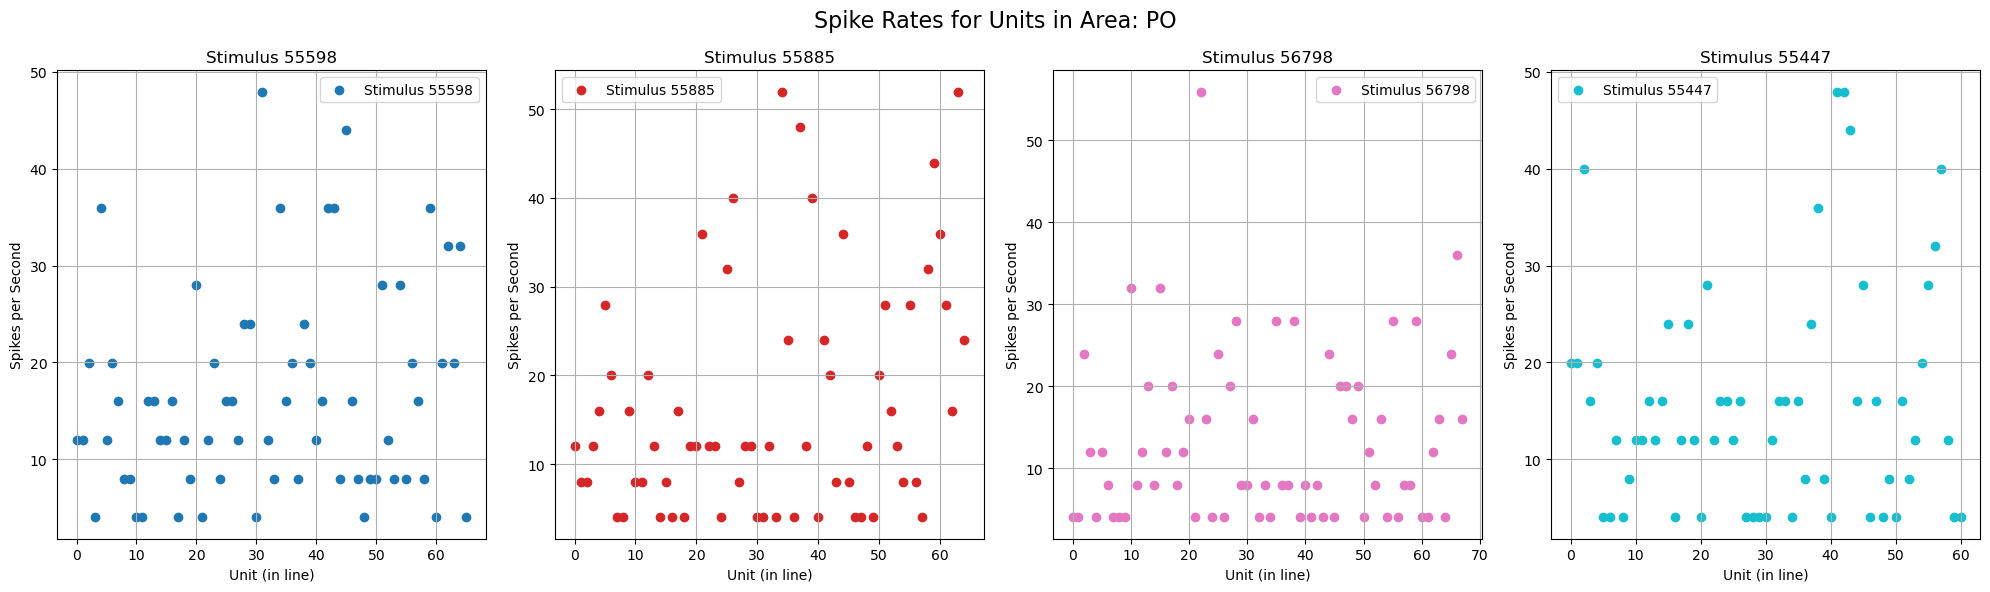

In [28]:
random_areas = ['LP', 'CA1', 'VISp', 'PO']

colors = plt.cm.get_cmap('tab10', 4)  

for i, area in enumerate(random_areas):
    stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
    random_stimuli = [55598, 55885, 56798, 55447]
    area_data = df[(df['area'] == area) & (df['stimulus_presentation_id'].isin(random_stimuli))]

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))  
    
    for j, stimulus in enumerate(random_stimuli):
        stimulus_data = area_data[area_data['stimulus_presentation_id'] == stimulus]
       
        axes[j].scatter(range(len(stimulus_data)), stimulus_data['spikes_per_second'],
                        color=colors(j), label=f'Stimulus {stimulus}')
        
        axes[j].set_title(f'Stimulus {stimulus}')
        axes[j].set_xlabel('Unit (in line)')
        axes[j].set_ylabel('Spikes per Second')
        axes[j].grid(True)
        axes[j].legend()

    fig.suptitle(f'Spike Rates for Units in Area: {area}', fontsize=16)

    plt.tight_layout()

    plt.show()


As we can see the spikes per second of each neuron within the same area are very different.

Our analysis will in fact be directed towards determing if an area is active or not. The way to determine this is set by us in the following way: if more than the 30% of the neurons in the area has the values of simulus_per_second larger than 10 then the area is considered active.

Now we want to verify something fundamental for our analysis: if different stimulus activate different areas of the brain. 

Let's consider four stimulus and see which areas are active in the four cases.

In [63]:
stimuli = [50785, 50177, 50061, 69940]

In [64]:
i = stimuli[0]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: MGm - active
Area: SGN - active
Area: LP - active
Area: DG - active
Area: ProS - active
Area: SUB - active
Area: VISp - active
Area: CA1 - active
Area: VISrl - active
Area: Eth - active
Area: TH - active
Area: APN - active
Area: VIS - active
Area: LGv - active
Area: CA3 - active
Area: VISl - inactive
Area: MRN - active
Area: MB - active
Area: NOT - inactive
Area: VISam - active
Area: PO - active
Area: LGd - active
Area: VISal - active


In [65]:
i = stimuli[1]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: MGm - active
Area: SGN - active
Area: LP - active
Area: DG - active
Area: ProS - active
Area: SUB - active
Area: VISp - active
Area: CA1 - active
Area: VISrl - active
Area: Eth - active
Area: TH - inactive
Area: APN - active
Area: VIS - active
Area: LGv - active
Area: CA3 - active
Area: VISl - active
Area: MRN - active
Area: MB - active
Area: NOT - active
Area: VISam - active
Area: PO - active
Area: LGd - active
Area: VISal - active


In [66]:
i = stimuli[2]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: MGm - active
Area: SGN - active
Area: LP - active
Area: DG - active
Area: ProS - active
Area: SUB - active
Area: VISp - inactive
Area: CA1 - active
Area: VISrl - active
Area: Eth - active
Area: TH - active
Area: APN - active
Area: VIS - inactive
Area: LGv - active
Area: CA3 - active
Area: VISl - inactive
Area: MRN - active
Area: MB - inactive
Area: NOT - active
Area: VISam - active
Area: PO - active
Area: LGd - inactive
Area: VISal - active


In [67]:
i = stimuli[3]
for area in df['area'].unique():
        stimuli_in_area = df[df['area'] == area]['stimulus_presentation_id'].unique()
        area_data = df[(df['area'] == area) & (df['stimulus_presentation_id']==i)]

        units = area_data['unit_id'].unique()
        units_with_high_spikes = area_data[area_data['spikes_per_second'] > 10]['unit_id'].unique()

        percentage = len(units_with_high_spikes) / len(units) * 100

        if percentage >= 30:
            print(f"Area: {area} - active")
        else:
            print(f"Area: {area} - inactive")

Area: MGm - active
Area: SGN - active
Area: LP - inactive
Area: DG - active
Area: ProS - active
Area: SUB - active
Area: VISp - inactive
Area: CA1 - active
Area: VISrl - inactive
Area: Eth - active
Area: TH - inactive
Area: APN - active
Area: VIS - active
Area: LGv - active
Area: CA3 - active
Area: VISl - inactive
Area: MRN - active
Area: MB - inactive
Area: NOT - active
Area: VISam - inactive
Area: PO - active
Area: LGd - inactive
Area: VISal - active


As we can see in the four cases we have four different situations. 

In particular, let's see the case of the area LP for the four stimuli.

/var/folders/l5/l2yq9xlj55l1p5qsn5c6n5wh0000gn/T/ipykernel_73471/2998519832.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 4)


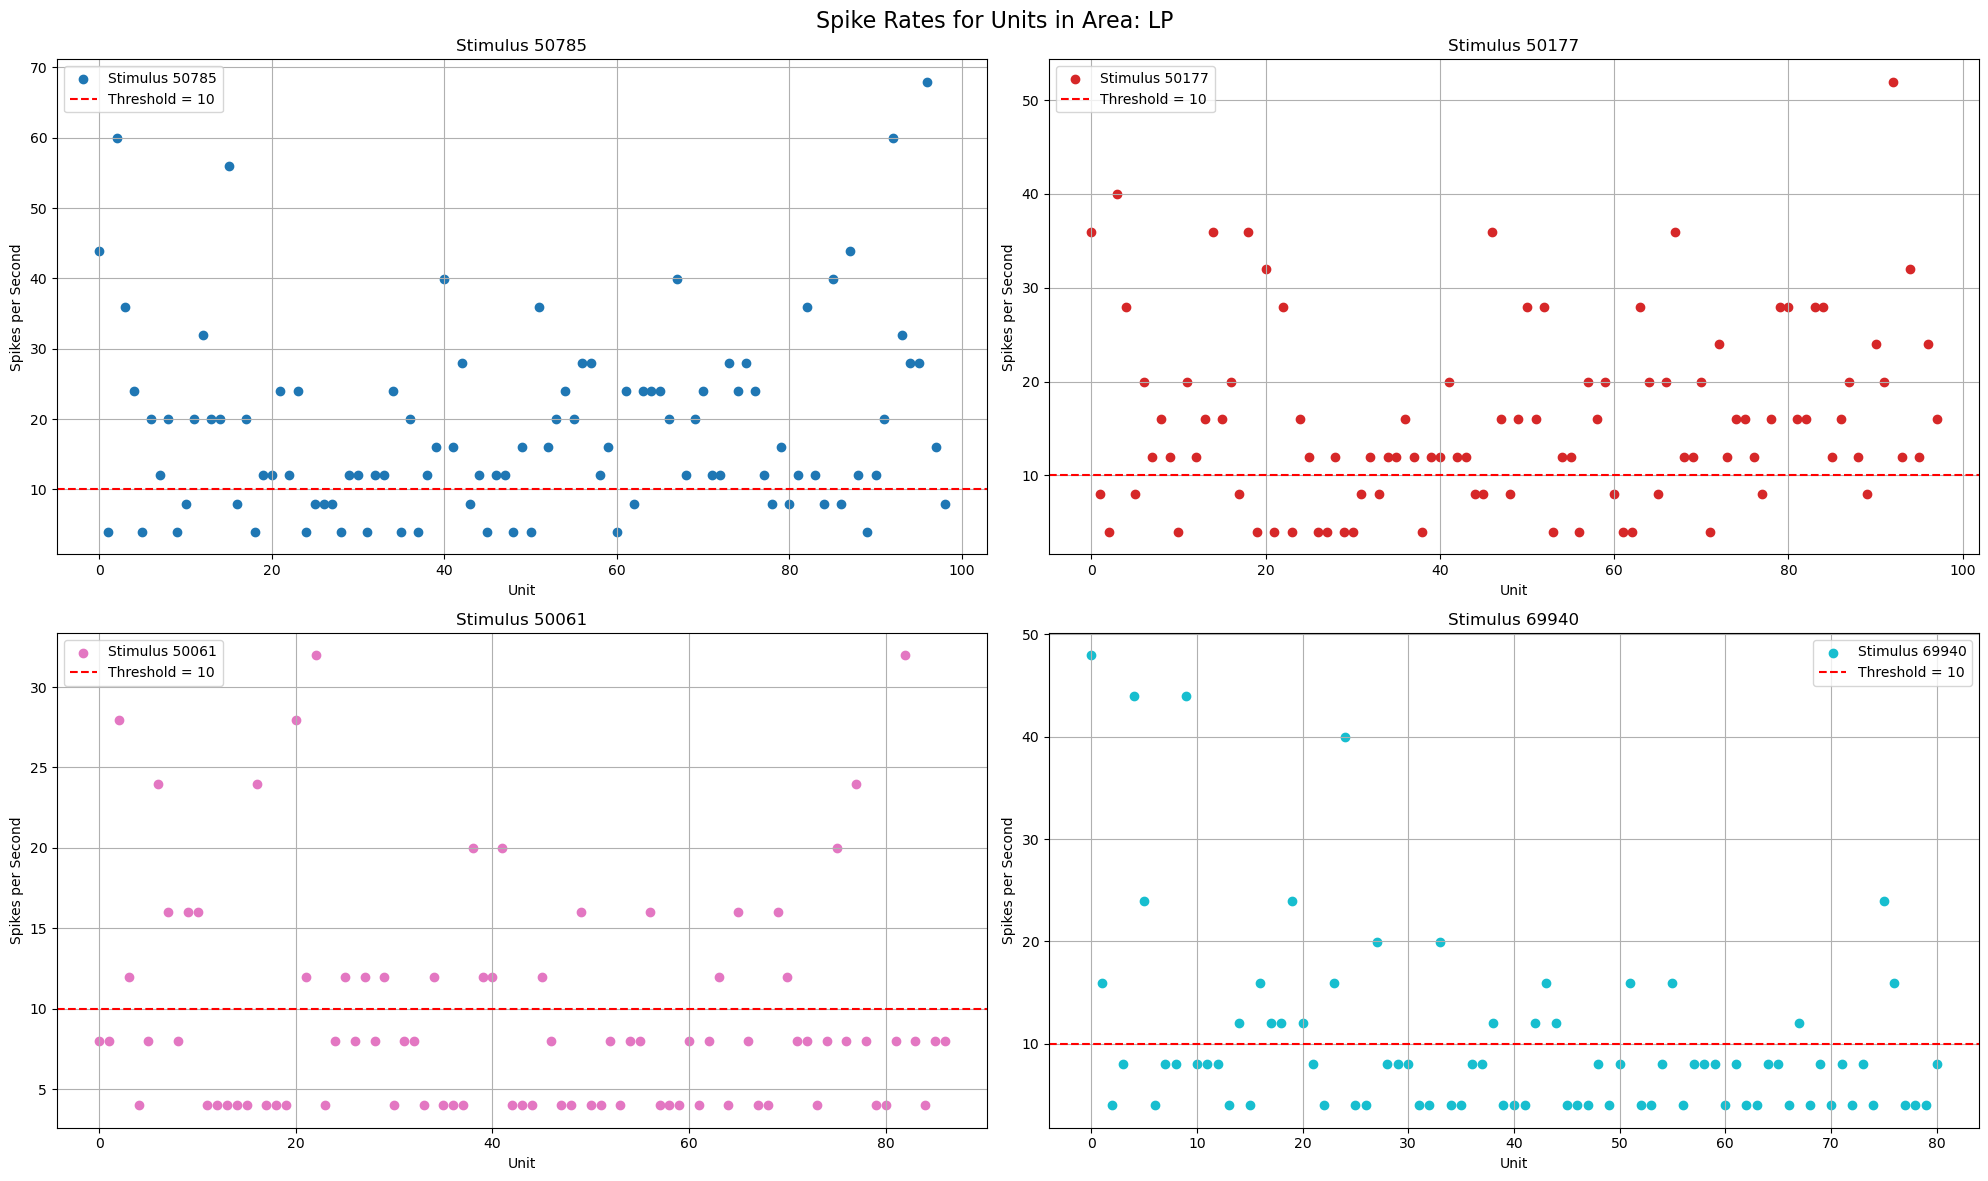

In [68]:
colors = cm.get_cmap('tab10', 4) 

fig, axes = plt.subplots(2, 2, figsize=(20, 12))  

axes = axes.flatten()

for j, stimulus in enumerate(stimuli):

    stimulus_data = df[(df['area'] == 'LP') & (df['stimulus_presentation_id'] == stimulus)]
   
    axes[j].scatter(range(len(stimulus_data)), stimulus_data['spikes_per_second'],
                    color=colors(j / 4), label=f'Stimulus {stimulus}')
    
    axes[j].axhline(y=10, color='red', linestyle='--', linewidth=1.5, label='Threshold = 10')
    
    axes[j].set_title(f'Stimulus {stimulus}')
    axes[j].set_xlabel('Unit')
    axes[j].set_ylabel('Spikes per Second')
    axes[j].grid(True)
    axes[j].legend()

fig.suptitle('Spike Rates for Units in Area: LP', fontsize=16)

plt.tight_layout()
plt.show()


As we can see in the first two cases, where LP is defined as active, most of the neurons have a spikes_per_second value above the threshold we set. In the second case, however, most of the neurons fall below the threshold, which makes sense since in these cases LP was judged to be inactive.

With this last step we finish the analysis of our data and we proceed by creating the dataset we will use in the following steps.

##  Creation of dataset for the analysis

We create a dataset with all the combinations of stimuli and areas, adding a new column, 'active', which takes the value 1 if the area is active under that stimulus and 0 if it is not.

In [71]:
def determine_active(group):
    total_units = group['unit_id'].nunique()  
    active_units = group[group['spikes_per_second'] > 10]['unit_id'].nunique()  
    
    if total_units == 0:
        return 0
    
    return 1 if (active_units / total_units) * 100 >= 30 else 0

In [72]:
new_df = df[['stimulus_presentation_id', 'area', 'spatial_frequency', 'orientation', 'spikes_per_second', 'unit_id']]

grouped_df = new_df.groupby(['stimulus_presentation_id', 'area']).apply(determine_active).reset_index(name='active')

final_df = grouped_df.merge(new_df[['stimulus_presentation_id', 'area', 'spatial_frequency', 'orientation']].drop_duplicates(),
                            on=['stimulus_presentation_id', 'area'], how='left')

final_df = final_df[['stimulus_presentation_id', 'area', 'spatial_frequency', 'orientation', 'active']]


In [73]:
final_df

,stimulus_presentation_id,area,spatial_frequency,orientation,active
0,49434,APN,0.32,0.0,1
1,49434,CA1,0.32,0.0,1
2,49434,CA3,0.32,0.0,1
3,49434,DG,0.32,0.0,1
4,49434,Eth,0.32,0.0,1
...,...,...,...,...,...
122948,70389,VISal,0.04,150.0,1
122949,70389,VISam,0.04,150.0,0
122950,70389,VISl,0.04,150.0,0
122951,70389,VISp,0.04,150.0,1


final_df.to_parquet('ourdata/df_static_session_757216464.parquet', index=False)